# Training Deep Neural Networks on a GPU with PyTorch

실행 플랫폼이 NVIDIA에서 제조한 GPU에 연결된 경우 그래픽 처리 장치(GPU)를 사용하여 모델을 더 빠르게 훈련할 수 있습니다. 선택한 플랫폼에서 GPU를 사용하려면 다음 지침을 따르십시오.

* Google Colab: 메뉴 옵션 "런타임 > 런타임 유형 변경"을 사용하고 "하드웨어 가속기" 드롭다운에서 "GPU"를 선택합니다.
* Kaggle: 사이드바의 "설정" 섹션에 있는 "가속기" 드롭다운에서 "GPU"를 선택합니다. 오른쪽 상단의 버튼을 사용하여 사이드바를 엽니다.
* Binder: Binder에서 실행되는 노트북은 GPU를 사용할 수 없습니다. Binder를 구동하는 시스템이 GPU에 연결되어 있지 않기 때문입니다.
* Linux: 노트북/데스크톱에 NVIDIA GPU(그래픽 카드)가 있는 경우 [NVIDIA CUDA 드라이버]
  (https://docs.nvidia.com/cuda/cuda-installation-    guide-linux/index .html).
* Windows: 노트북/데스크탑에 NVIDIA GPU(그래픽 카드)가 있는 경우 [NVIDIA CUDA 드라이버]
  (https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows /index.html).
* macOS: macOS는 NVIDIA GPU와 호환되지 않습니다.

GPU에 액세스할 수 없거나 GPU가 무엇인지 확실하지 않더라도 걱정하지 마십시오. GPU 없이도 이 튜토리얼의 모든 코드를 실행할 수 있습니다.

# Preparing the Data

이전 튜토리얼에서 약 86%의 정확도로 MNIST 데이터 세트에서 손으로 쓴 숫자를 식별하기 위해 로지스틱 회귀 모델을 학습했습니다. 데이터 세트는 손으로 쓴 숫자(0~9)의 28px x 28px 회색조 이미지와 각 이미지가 나타내는 숫자를 나타내는 레이블로 구성됩니다. 다음은 데이터세트의 샘플 이미지입니다.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

우리는 로지스틱 회귀 모델의 정확도를 87% 이상으로 향상시키는 것이 상당히 어렵다는 것을 알았습니다. 모델이 픽셀 강도와 이미지 레이블 간의 선형 관계를 가정하기 때문입니다. 이 게시물에서는 입력과 대상 간의 비선형 관계를 캡처할 수 있는 피드 포워드 신경망을 사용하여 이를 개선하려고 합니다.

torch, torchvision, numpy 및 matplotlib에서 필요한 모듈과 클래스를 설치하고 가져오는 것으로 시작하겠습니다.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', train=True, transform=ToTensor())
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [3]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

인수 num_workers 및 pin_memory의 목적은 https://pytorch.org/docs/stable/data.html 문서를 살펴보십시오.

torchvision의 make_grid 기능을 사용하여 그리드의 데이터 배치를 시각화해 보겠습니다. 또한 텐서에서 .permute 메서드를 사용하여 matplotlib에서 예상한 대로 채널을 마지막 차원으로 이동합니다.

images.shape: torch.Size([128, 1, 28, 28])


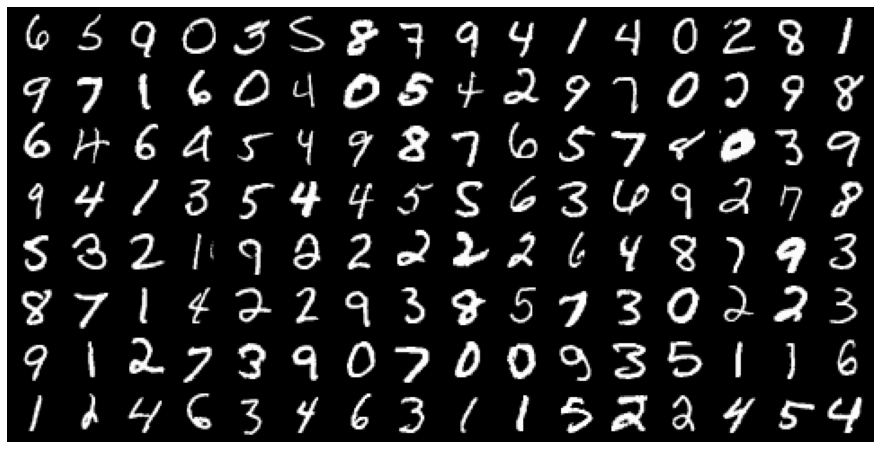

In [4]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

----------------------------------------------------------------------------------------------------------------------------------------

## Hidden Layers, Activation Functions and Non-Linearity

우리는 hidden layer와 output layer라는 두 개의 레이어가 있는 신경망을 만들 것입니다. 또한 두 레이어 사이에 활성화 함수를 사용할 것입니다. 숨겨진 레이어와 활성화 함수가 입력과 출력 간의 비선형 관계를 캡처하는 데 어떻게 도움이 되는지 알아보기 위해 단계별 예제를 살펴보겠습니다.

먼저 입력 텐서 배치를 생성해 보겠습니다. 1x28x28 이미지를 nn.Linear 객체로 전달할 수 있도록 784 크기의 벡터로 평면화(flatten)합니다.

In [5]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break 

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


다음으로, hidden 레이어 역할을 할 nn.Linear 객체를 생성해 보겠습니다. 숨겨진 레이어의 출력 크기를 32로 설정합니다. 이 숫자는 모델의 학습 용량을 변경하기 위해 늘리거나 줄일 수 있습니다.

In [6]:
input_size = inputs.shape[-1]
hidden_size = 32
layer1 = nn.Linear(input_size, hidden_size)

In [9]:
inputs.shape

torch.Size([128, 784])

In [10]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


크기 '784'의 이미지 벡터는 'layer1'의 전치된 가중치 행렬과 'inputs' 행렬의 행렬 곱셈을 수행하고 바이어스를 추가하여 길이 '32'의 중간 출력 벡터로 변환됩니다. torch.allclose를 사용하여 이를 확인할 수 있습니다. 자세한 설명은 선형 회귀에 대한 튜토리얼을 검토하세요.

In [11]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [12]:
# .allclose 메서드는 모든 input 및 other가 조건을 충족하는지 확인합니다.
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

따라서 layer1_outputs 및 inputs 는 선형 관계를 갖습니다. 즉, layer_outputs의 각 요소는 inputs 요소의 가중 합입니다. 따라서 모델을 훈련하고 가중치를 수정하더라도 layer1은 '입력'과 '출력' 간의 선형 관계만 캡처할 수 있습니다.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

다음으로 ReLU(Rectified Linear Unit) 함수를 출력의 활성화 함수로 사용합니다. relu(x) = max(0,x) 공식이 있습니다. 즉, 단순히 주어진 텐서의 음수 값을 값 0으로 대체합니다. ReLU는 시각적으로 볼 수 있듯이 비선형 함수입니다.

<img src="https://i.imgur.com/yijV4xF.png" width="420">

텐서의 요소에 ReLU를 적용하기 위해  `F.relu`  메서드를 사용할 수 있습니다.

In [13]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

활성화 함수를 layer1_outputs에 적용하고 음수 값이 0으로 대체되었는지 확인합니다.

In [14]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7059464454650879
min(relu_outputs): 0.0


이제 비선형 활성화 함수를 적용했으므로 relu_outputs와 inputs는 선형 관계가 아닙니다. 우리는 'ReLU'를 _활성화 함수_라고 부릅니다. 
각 입력에 대해 특정 출력이 활성화되고(0이 아닌 값을 가진 출력) 다른 출력은 꺼지기 때문입니다(0 값을 가진 출력).

다음으로, relu_outputs에 있는 hidden_size 길이의 벡터를 길이 10의 벡터로 변환하기 위한 출력 레이어를 생성해 보겠습니다.

In [15]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [16]:
inputs.shape

torch.Size([128, 784])

예상대로 layer2_outputs에는 크기가 10인 벡터 배치가 포함되어 있습니다. 이제 이 출력을 사용하여 F.cross_entropy를 사용하여 손실을 계산하고 경사 하강법을 사용하여 layer1 및 layer2의 가중치를 조정할 수 있습니다.

In [17]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3376, grad_fn=<NllLossBackward>)

따라서 우리 모델은 선형 변환(layer1 사용), 비선형 활성화(F.relu 사용), 또 다른 선형 변환(layer2 사용)을 적용하여 inputs을 layer2_outputs로 변환합니다. 기본 행렬 연산을 사용하여 출력을 다시 계산하여 이를 확인합니다.

In [18]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

torch.allclose(outputs, layer2_outputs, 1e-3)

True

outputs 및 inputs는 비선형 활성화 함수인 F.relu로 인해 선형 관계가 없습니다. 모델을 훈련하고 layer1 및 layer2의 가중치를 조정하면 이제 이미지와 레이블 간의 비선형 관계를 캡처할 수 있습니다. 즉, 비선형성을 도입하면 모델이 더욱 강력하고 다양해집니다. 또한 hidden_size는 입력 또는 출력의 차원에 의존하지 않으므로 모델 내 매개변수의 수를 늘리기 위해 변경합니다. 또한 새로운 숨겨진 레이어를 도입하고 각 숨겨진 레이어 후에 동일한 비선형 활성화를 적용할 수 있습니다.

방금 만든 모델을 신경망이라고 합니다. _심층 신경망_은 단순히 하나 이상의 숨겨진 레이어가 있는 신경망입니다. 실제로 Universal Approximation Theorem에 따르면 충분히 크고 깊은 신경망은 임의의 함수를 계산할 수 있습니다. 여기 몇 가지 예가 있어요.

* 이미지에 고양이 또는 개가 포함되어 있는지 식별(또는 다른 것)
* 10초 샘플을 사용하여 노래의 장르 식별
* 내용에 따라 영화 리뷰를 긍정적 또는 부정적으로 분류
* 도로 영상 피드를 이용한 자율주행차 내비게이션
* 영어에서 프랑스어(및 수백 가지 다른 언어)로 문장 번역
* 음성 녹음을 텍스트로 또는 그 반대로 변환
* 그리고 더 많은...

입력에 무작위로 초기화된 행렬을 곱하고, 비선형 활성화를 적용하고, 그래디언트 디센트를 사용하여 반복적으로 가중치를 조정하는 간단한 프로세스가 어떻게 놀라운 결과를 얻을 수 있는지 상상하기 어렵습니다. 딥러닝 모델에는 종종 인간의 두뇌가 이해할 수 있는 것보다 훨씬 더 복잡한 관계를 캡처할 수 있는 수백만 개의 매개 변수가 포함되어 있습니다.

두 선형 레이어 사이에 비선형 활성화를 포함하지 않았다면 입력과 출력 간의 최종 관계는 여전히 선형일 것입니다. 계산의 간단한 리팩토링이 이를 보여줍니다.

In [19]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [20]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [21]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [22]:
torch.allclose(outputs2, outputs3, 1e-3)

True

----------------------------------------------------------------------------------------------------------------------------------------

## Model

이제 모델을 정의할 준비가 되었습니다. 위에서 설명한 것처럼 하나의 숨겨진 레이어가 있는 신경망을 만듭니다. 이것이 의미하는 바는 다음과 같습니다.

* 단일 nn.Linear 개체를 사용하여 입력 배치(픽셀 강도)를 출력(클래스 확률)으로 변환하는 대신 두 개의 nn.Linear 개체를 사용합니다. 이들 각각은 네트워크에서 _계층_이라고 합니다.

* 첫 번째 레이어(숨겨진 레이어라고도 함)는 batch_size x 784 모양의 입력 행렬을 batch_size x hidden_size 모양의 중간 출력 행렬로 변환합니다. 'hidden_size' 매개변수는 수동으로 구성할 수 있습니다(예: 32 또는 64).

* 그런 다음 비선형 활성화 함수를 중간 출력에 적용합니다. 활성화 함수는 행렬의 개별 요소를 변환합니다.

* 크기가 batch_size x hidden_size인 활성화 함수의 결과는 두 번째 레이어(출력 레이어라고도 함)로 전달됩니다. 두 번째 레이어는 그것을 'batch_size x 10' 크기의 행렬로 변환합니다. 이 출력을 사용하여 손실을 계산하고 경사 하강법을 사용하여 가중치를 조정할 수 있습니다.

위에서 설명한 것처럼 모델에는 하나의 숨겨진 레이어가 포함됩니다. 시각적으로 보면 다음과 같습니다.

<img src="https://i.imgur.com/eN7FrpF.png" width="480">

PyTorch에서 `nn.Module` 클래스를 확장하여 모델을 정의해 보겠습니다.

In [34]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hid_size)
        # output layer
        self.linear2 = nn.Linear(hid_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

또한 입력 배치에 대한 모델 예측의 정확도를 계산하는 'accuracy' 함수를 정의해야 합니다. 위의 validation_step에서 사용됩니다.

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

32개의 활성화가 있는 히든 레이어가 포함된 모델을 생성합니다.

In [36]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

model = MnistModel(input_size, hidden_size, num_classes)

모델의 매개변수를 살펴보겠습니다. 각 레이어에 대해 하나의 가중치 및 편향 행렬이 표시될 것으로 예상합니다.

In [37]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


모델을 사용하여 몇 가지 출력을 생성해 봅시다. 데이터 세트에서 128개 이미지의 첫 번째 배치를 가져와 모델에 전달합니다.

In [42]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.320209264755249
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0443, -0.0772,  0.1637,  0.1598,  0.2803, -0.1471,  0.0444, -0.0348,
          0.1819, -0.1629],
        [-0.0008, -0.0579,  0.1597,  0.1325,  0.2588, -0.1303,  0.1529,  0.0159,
          0.2012, -0.0235]])


----------------------------------------------------------------------------------------------------------------------------------------

## Using a GPU

모델 및 데이터 세트의 크기가 증가함에 따라 GPU를 사용하여 합리적인 시간 내에 모델을 교육해야 합니다. GPU에는 부동 소수점 숫자에 대해 값비싼 행렬 연산을 신속하게 수행하도록 최적화된 수백 개의 코어가 포함되어 있어 심층 신경망 교육에 이상적입니다. Google Colab 및 Kaggle에서 GPU를 무료로 사용하거나 서비스에서 GPU 기반 머신을 대여할 수 있습니다. Google Cloud Platform, Amazon Web Services, 및 Paperspace.

GPU를 사용할 수 있고 필요한 NVIDIA CUDA 드라이버가 torch.cuda.is_available을 사용하여 설치되었는지 확인할 수 있습니다.

In [43]:
torch.cuda.is_available()

True

우리의 코드가 가능한 경우 GPU를 사용하고 그렇지 않은 경우 기본적으로 CPU를 사용하도록 헬퍼 함수를 정의해 봅시다.

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [45]:
device = get_default_device()
device

device(type='cuda')

마지막으로 'DeviceDataLoader' 클래스를 정의하여 기존 데이터 로더를 래핑하고 데이터 배치를 선택한 장치로 이동합니다. 흥미롭게도 PyTorch datal oader를 생성하기 위해 기존 클래스를 확장할 필요가 없습니다. 필요한 것은 배치 데이터를 검색하는 __iter__ 메서드와 배치 수를 가져오는 __len__ 메서드뿐입니다.

In [46]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b, c in self.dl: 
            yield b.to(self.device), c.to(self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

이제 DeviceDataLoader를 사용하여 데이터 로더를 래핑할 수 있습니다.

In [47]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

GPU로 옮겨진 Tensor는 cuda라는 단어를 포함하는 device 속성을 가집니다. valid_dl의 데이터 배치를 살펴봄으로써 이를 검증해 봅시다.

In [48]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 6, 7, 4, 6, 6, 5, 0, 1, 4, 7, 6, 6, 8, 1, 9, 3, 8, 3, 8, 8, 5, 1, 3,
        2, 6, 4, 4, 2, 2, 7, 6, 7, 8, 7, 8, 2, 7, 2, 8, 5, 7, 1, 9, 8, 6, 0, 0,
        3, 0, 1, 5, 6, 4, 5, 0, 3, 5, 2, 4, 4, 7, 3, 2, 5, 4, 7, 6, 5, 7, 6, 8,
        0, 4, 6, 5, 9, 8, 6, 6, 5, 4, 6, 2, 5, 0, 3, 7, 3, 6, 9, 6, 0, 1, 8, 2,
        6, 4, 1, 1, 6, 5, 0, 6, 6, 9, 2, 2, 7, 6, 0, 6, 5, 9, 0, 1, 9, 1, 1, 2,
        0, 0, 0, 1, 7, 8, 5, 6, 0, 5, 2, 6, 8, 1, 4, 1, 6, 5, 3, 7, 1, 4, 7, 6,
        9, 4, 3, 8, 8, 5, 8, 4, 2, 7, 7, 7, 9, 3, 0, 9, 5, 5, 9, 1, 0, 7, 1, 8,
        7, 3, 1, 2, 0, 9, 2, 6, 7, 1, 3, 9, 5, 8, 0, 0, 4, 5, 5, 8, 6, 0, 5, 8,
        0, 6, 8, 4, 3, 9, 9, 1, 5, 7, 8, 2, 9, 7, 8, 6, 4, 9, 3, 6, 8, 5, 5, 2,
        9, 5, 5, 5, 1, 0, 9, 1, 5, 9, 7, 4, 3, 3, 1, 6, 6, 0, 3, 1, 1, 9, 4, 2,
        2, 9, 6, 8, 6, 8, 0, 4, 2, 0, 4, 2, 5, 4, 6, 2], device='cuda:0')


----------------------------------------------------------------------------------------------------------------------------------------

## Training the Model

기울기 하강법을 사용하여 모델을 훈련하고 유효성 검사 세트에서 성능을 평가하기 위해 fit 및 evaluate의 두 가지 함수를 정의합니다. 이러한 기능에 대한 자세한 연습은 이전 자습서를 확인하세요.

In [49]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

모델을 교육하기 전에 데이터와 모델의 매개변수(가중치 및 편향)가 동일한 장치(CPU 또는 GPU)에 있는지 확인해야 합니다. 모델의 매개변수를 올바른 장치로 이동하기 위해 to_device 함수를 재사용할 수 있습니다.

In [51]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size, num_classes)
model.to(device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

초기 가중치 및 편향 세트를 사용하여 검증 세트에서 모델이 어떻게 수행되는지 살펴보겠습니다.

In [52]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.307135820388794, 'val_acc': 0.16171875596046448}]

초기 정확도는 무작위로 초기화된 모델에서 예상할 수 있는 것처럼 약 10%입니다(무작위로 추측하여 레이블을 올바르게 얻을 확률이 1/10이므로).

다섯 에포크 동안 모델을 학습시키고 결과를 살펴보겠습니다. 0.5라는 상대적으로 높은 학습률을 사용할 수 있습니다.

In [53]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2387, val_acc: 0.9297
Epoch [1], val_loss: 0.2037, val_acc: 0.9376
Epoch [2], val_loss: 0.1407, val_acc: 0.9599
Epoch [3], val_loss: 0.1305, val_acc: 0.9607
Epoch [4], val_loss: 0.1420, val_acc: 0.9578


96% 꽤 좋습니다! 정확도를 더욱 향상시키기 위해 0.1의 더 낮은 학습률에서 5개의 에포크를 더 모델을 훈련시키겠습니다.

In [54]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1075, val_acc: 0.9652
Epoch [1], val_loss: 0.1050, val_acc: 0.9685
Epoch [2], val_loss: 0.1081, val_acc: 0.9661
Epoch [3], val_loss: 0.1055, val_acc: 0.9667
Epoch [4], val_loss: 0.1049, val_acc: 0.9675


이제 시간이 지남에 따라 모델이 어떻게 개선되는지 연구하기 위해 손실 및 정확도를 플로팅할 수 있습니다.

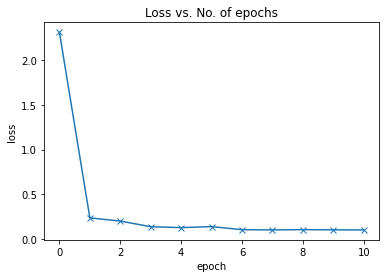

In [55]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

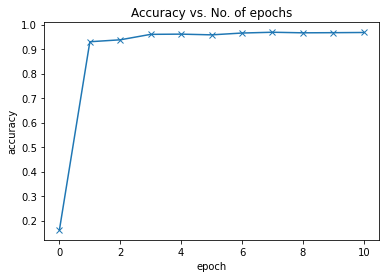

In [56]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

우리의 현재 모델은 로지스틱 회귀 모델(약 86%의 정확도만 달성할 수 있음)을 상당한 마진으로 능가합니다! 97%의 정확도에 빠르게 도달하지만 이 이상은 크게 향상되지 않습니다. 정확도를 더 높이려면 숨겨진 레이어의 크기를 늘리거나 활성화된 숨겨진 레이어를 더 추가하여 모델을 더 강력하게 만들어야 합니다. 이 두 가지 접근 방식을 모두 시도해보고 어느 것이 더 효과적인지 알아보시기 바랍니다.

## Testing with individual images

지금까지 모델의 전반적인 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 살펴보는 것도 좋은 생각입니다. 미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠습니다. 먼저 ToTensor 변환으로 테스트 데이터 세트를 재생성합니다.

In [57]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [58]:
len(test_dataset)
img, label = test_dataset[0]
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [59]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


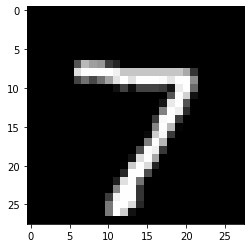

In [60]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


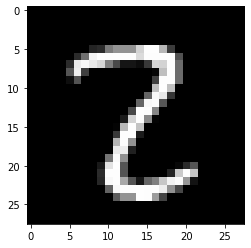

In [61]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


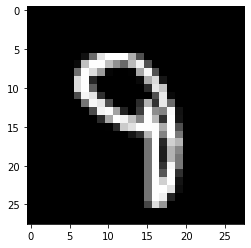

In [62]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델이 제대로 작동하지 않는 부분을 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다.

마지막 단계로 테스트 세트에서 모델의 전반적인 손실과 정확도도 살펴보겠습니다.

In [63]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09826751798391342, 'val_acc': 0.970019519329071}

이것이 검증 세트의 정확도/손실과 유사할 것으로 예상합니다. 그렇지 않은 경우 테스트 세트(종종 실제 데이터에서 가져옴)와 유사한 데이터 및 분포를 가진 더 나은 유효성 검사 세트가 필요할 수 있습니다.

## Exercises
지금까지 배운 개념과 기술을 적용하려면 다음 연습을 시도하십시오.

종단 간 모델 교육에 대한 코딩 연습: https://jovian.ai/aakashns/03-cifar10-feedforward
딥러닝 모델을 위한 스타터 노트북: https://jovian.ai/aakashns/fashion-feedforward-minimal

훌륭한 기계 학습 모델을 안정적으로 교육하려면 연습과 경험이 필요합니다. 다양한 데이터 세트, 모델 및 하이퍼파라미터로 실험해 보십시오. 이것이 이 기술을 습득하는 가장 좋은 방법입니다.